In [35]:
import pandas as pd
import os
import s3fs # for reading from S3FileSystem
import json

%matplotlib inline
import matplotlib.pyplot as plt


import torch.nn as nn
import torch
import torch.utils.model_zoo as model_zoo
import numpy as np

import torchvision.models as models # To get ResNet18

# From - https://github.com/cfotache/pytorch_imageclassifier/blob/master/PyTorch_Image_Inference.ipynb
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from PIL import Image
from torch.autograd import Variable

from torch.utils.data.sampler import SubsetRandomSampler

# Prepare the Model

In [2]:
SAGEMAKER_PATH = r'/home/ec2-user/SageMaker'

MODEL_PATH = os.path.join(SAGEMAKER_PATH, r'sidewalk-cv-assets19/pytorch_pretrained/models/20e_slid_win_no_feats_r18.pt')

In [3]:
os.path.exists(MODEL_PATH)

True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# Use PyTorch's ResNet18
# https://stackoverflow.com/questions/53612835/size-mismatch-for-fc-bias-and-fc-weight-in-pytorch
model = models.resnet18(num_classes=5)  

In [45]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Prep Data

In [17]:
# From Galen

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# the dataset loads the files into pytorch vectors
#image_dataset = TwoFileFolder(dir_containing_crops, meta_to_tensor_version=2, transform=data_transform)

# the dataloader takes these vectors and batches them together for parallelization, increasing performance
#dataloader    = torch.utils.data.DataLoader(image_dataset, batch_size=4, shuffle=True, num_workers=4)

# this is the number of additional features provided by the dataset
#len_ex_feats = image_dataset.len_ex_feats
#dataset_size = len(image_dataset)

In [81]:
# Load in the data
data_dir = 'images'

data = datasets.ImageFolder(data_dir, transform=test_transforms)
classes = data.classes

In [82]:
!ls -a images

.   0_present  2_surface_prob  4_null
..  1_missing  3_obstacle      .ipynb_checkpoints


In [83]:
!rm -f -r images/.ipynb_checkpoints/

In [84]:
# Examine the classes based on folders... 
# Need to make sure that we don't get a .ipynb_checkpoints as a folder
# Discussion here - https://forums.fast.ai/t/how-to-remove-ipynb-checkpoint/8532/19
classes

['.ipynb_checkpoints',
 '0_present',
 '1_missing',
 '2_surface_prob',
 '3_obstacle',
 '4_null']

In [101]:
num = 10

indices = list(range(len(data)))
print(indices)
np.random.shuffle(indices)
idx = indices[:num]

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

#sampler = SubsetRandomSampler(idx)
loader = torch.utils.data.DataLoader(data, batch_size=num)
dataiter = iter(loader)
images, labels = dataiter.next()

[0, 1, 2, 3]


In [102]:
len(images)

4

In [103]:
# Look at the first image
images[0]

tensor([[[0.3725, 0.3686, 0.3686,  ..., 0.5529, 0.5451, 0.5412],
         [0.3647, 0.3608, 0.3608,  ..., 0.5569, 0.5529, 0.5490],
         [0.3529, 0.3529, 0.3529,  ..., 0.5686, 0.5686, 0.5647],
         ...,
         [0.3882, 0.3843, 0.3843,  ..., 0.4235, 0.4275, 0.4314],
         [0.3882, 0.3843, 0.3843,  ..., 0.4314, 0.4353, 0.4392],
         [0.3882, 0.3843, 0.3843,  ..., 0.4353, 0.4431, 0.4471]],

        [[0.3647, 0.3608, 0.3608,  ..., 0.5569, 0.5490, 0.5451],
         [0.3569, 0.3529, 0.3529,  ..., 0.5647, 0.5569, 0.5529],
         [0.3451, 0.3451, 0.3451,  ..., 0.5765, 0.5765, 0.5725],
         ...,
         [0.3922, 0.3882, 0.3882,  ..., 0.4392, 0.4431, 0.4471],
         [0.3922, 0.3882, 0.3882,  ..., 0.4471, 0.4510, 0.4549],
         [0.3922, 0.3882, 0.3882,  ..., 0.4510, 0.4588, 0.4627]],

        [[0.3059, 0.3020, 0.3020,  ..., 0.5647, 0.5569, 0.5529],
         [0.2980, 0.2941, 0.2941,  ..., 0.5647, 0.5608, 0.5569],
         [0.2863, 0.2863, 0.2863,  ..., 0.5725, 0.5725, 0.

In [104]:
len(labels)

4

In [105]:
labels

tensor([1, 1, 2, 2])

# Execute Inference on 2 Sample Images

In [106]:
# Note on how to make sure the model and the input tensors are both on cuda device (gpu)
# https://discuss.pytorch.org/t/runtimeerror-input-type-torch-cuda-floattensor-and-weight-type-torch-floattensor-should-be-the-same/21782/6

In [107]:
def predict_image(image, model):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index, output  

index: 3
output: tensor([[-0.2533,  0.2435, -0.3366,  5.1900, -4.6836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
index: 3
output: tensor([[-0.2533,  0.2435, -0.3366,  5.1900, -4.6836]], device='cuda:0',
       grad_fn=<AddmmBackward>)
index: 3
output: tensor([[-0.4240,  0.8602, -2.7293,  3.3282, -0.9938]], device='cuda:0',
       grad_fn=<AddmmBackward>)
index: 3
output: tensor([[-0.2533,  0.2435, -0.3366,  5.1900, -4.6836]], device='cuda:0',
       grad_fn=<AddmmBackward>)


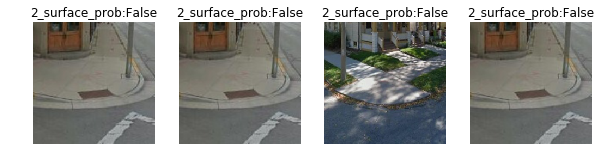

In [108]:
to_pil = transforms.ToPILImage()
#images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index, output = predict_image(image, model)
    print(f'index: {index}')
    print(f'output: {output}')
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [109]:
res

False

# Comments and Questions

What's the order of the labels (and how I should order the folders for the input data?) 

This file implies that there are different orders
https://github.com/ProjectSidewalk/sidewalk-cv-assets19/blob/master/GSVutils/sliding_window.py

```label_from_int = ('Curb Cut', 'Missing Cut', 'Obstruction', 'Sfc Problem')
pytorch_label_from_int = ('Missing Cut', "Null", 'Obstruction', "Curb Cut", "Sfc Problem")```